# ⌛ Maintenance period

|   |   |
|---|---|
| Project  |    [Segmentation des clients d'un site e-commerce](#https://openclassrooms.com/fr/paths/148/projects/630/assignment)         |
| Date   |   January 2023   |
| Autor  | Ana Bernal                                                    |
| Data source | https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce |
| Mentor | Samir Tanfous | 
| Notebook number  | 2 over 3                                                    |

**Description:** In this notebook we find a period of time for which it is necessary to update the clustering model to keep the customer segmentation up to  date.

# Table of contents
- [Preliminiaries](#Preliminiaries)
  - [Imports](#Imports)
  - [Graphics and options](#Graphics-and-options)
  - [Data](#Data)
- [Rand index calculations](#Rand-index-calculations)
  - [Calculating ARI every week](#Calculating-ARI-every-week)
- [Maintenance time](#Maintenance-time)

# Preliminiaries

## Imports

In [2]:
# Built in
import random

# Data processing and math
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import adjusted_rand_score

# Others
import pickle

# Warnings
import warnings

## Graphics and options

In [3]:
# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore")

## Data

In [4]:
path     = './data'
filename = 'data_for_simulation.csv'

In [5]:
# Read and preview our main dataframe
df = pd.read_csv(path + filename)
df.head(3)

,frequency,review_score_avg,recency_days,payment_value_avg,item_quant_avg,price_item_avg,order_purchase_timestamp
0,1,5.0,115,141.90,1.0,129.9,2018-05-10 10:56:27
1,1,4.0,118,27.19,1.0,18.9,2018-05-07 11:11:27
2,1,3.0,541,86.22,1.0,69.0,2017-03-10 21:05:03


In [8]:
# Renaming date column
df.rename(columns={'order_purchase_timestamp':'date'}, inplace=True)
df['date'] = pd.to_datetime(df.date)

# Rand index calculations

We will now measure the stability of the chosen model: **KMeans, n_clusters = 6**.

For this we use the Rand index with `sklearn.metrics.adjusted_rand_score`. This metric measure the similarity between two clusterings.

Concretely we choose a date : 60 weeks after the minimal date of purchase in the database. This choice allows to have sufficient rows in the dataframe. We train the model with this data to obtain an initial model. Then we do the same, adding the rows of purchases made up to one week after the initial date and we train a new model. We compare the initial model(and its prediction on new observations) and the new model by calculating the ARI. We iterate this process comparing the initial model with a whole new model for the data two weeks later, etc.

The sequence of ARI obtained is then a decreasing sequence.

The period of maintenance is then defined by the maximum number of weeks for which the ARI stayed over **0.8** which is a good indicator.

In [14]:
def ARI_score(start, df, date_label,columns,weeks=0, days=0, **kwargs):
    """
    Returns a dictionary with two items: 
    
    key : 'score'
    is the ARI comparing labels_true, labels_predict, where labels_true
    is KMeans clustering at the date start+weeks+days and labels_predict 
    is the prediction of a model made in the start date.

    key : ' new_clients'
    is the number of clients

    Parameters:
        - start: pd.Timestamp
        - weeks, days: int
            number of weeks and days after start date
            to calculate ARI.
        - data: pd.DataFrame
        - date_label: str
            The label of the date column
        - columns: list of str
            The labels of the columns to fit the models
    """
    # Start dataframe
    df0 = df.loc[df[date_label] < start]
    df0 = df0[columns]
    # Scale
    sc0 = StandardScaler().fit(df0)
    df0 = sc0.transform(df0)
    # Model and fit
    cls0 = KMeans(n_clusters=6)
    cls0.fit(df0)

    if 'new' in kwargs:
        new_date = kwargs['new']
    else:
        new_date = start + pd.Timedelta(weeks = weeks, days = days)
    
    # Second dataframe
    df1 = df.loc[df[date_label] < new_date]
    df1 = df1[columns]
    # Scale
    sc1 = StandardScaler().fit(df1)
    df1_scaled1 = sc1.transform(df1)
    # Model and fit
    cls1 = KMeans(n_clusters=6)
    cls1.fit(df1_scaled1)

    # Labels to compare
    new_labels = cls1.labels_
    df1_scaled0 = sc0.transform(df1)
    labels_old_model = cls0.predict(df1_scaled0)

    # Calculating score
    score = adjusted_rand_score(labels_old_model, new_labels)

    # Calculating number of new clients
    new_clients = df1.shape[0] - df0.shape[0]

    result = {'score' : score, 'new_clients' : new_clients}

    return result 

## Calculating ARI every week

The following loop calculates ARI as explained above. 

In [18]:
# Storing ARI and other info
ARI_metrics = {
    'start' : [],
    'end' : [],
    'weeks_after_start' : [],
    'ARI' : [],
    'new_clients' : []
}

# Defining start date and last day of database
today = df.date.max() #  Timestamp('2018-08-29 15:00:37')
start = df.date.min() + pd.Timedelta(weeks=60) #  Timestamp('2017-11-26 22:07:52')

# Initial conditions for while loop
i = 1
new_date = start + pd.Timedelta(weeks = i)
keep_going = True

while keep_going == True:

    if new_date > today:
        new_date = today

    ARI_metrics['start'].append(start)
    ARI_metrics['end'].append(new_date)
    ARI_metrics['weeks_after_start'].append(i)

    ARI_result = ARI_score(
        start, 
        df, 
        date_label='date', 
        columns=[
            'frequency', 
            'review_score_avg',
            'recency_days',
            'payment_value_avg',
            'item_quant_avg',
            'price_item_avg'
            ], 
        new = new_date
        )
    ARI_metrics['ARI'].append(ARI_result['score'])
    ARI_metrics['new_clients'].append(ARI_result['new_clients'])

    if new_date == today:
        keep_going = False
    
    i += 1

    new_date = start + pd.Timedelta(weeks = i)
    
    if start == today:
        keep_going = False

In [19]:
# Turning results into a dataframe
ARI_metrics_df = pd.DataFrame(ARI_metrics)
ARI_metrics_df.head(5)

,start,end,weeks_after_start,ARI,new_clients
0,2017-11-26 22:07:52,2017-12-03 22:07:52,1,0.939047,2039
1,2017-11-26 22:07:52,2017-12-10 22:07:52,2,0.897342,3651
2,2017-11-26 22:07:52,2017-12-17 22:07:52,3,0.863668,5009
3,2017-11-26 22:07:52,2017-12-24 22:07:52,4,0.843964,5976
4,2017-11-26 22:07:52,2017-12-31 22:07:52,5,0.823590,6831


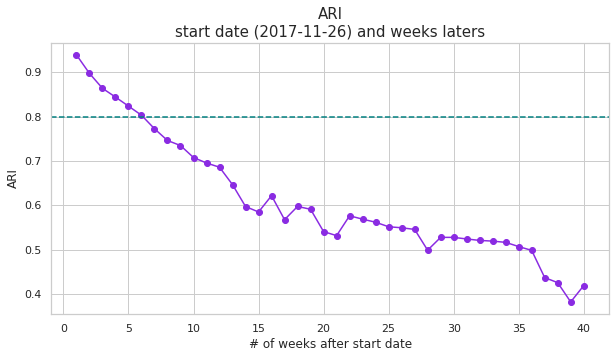

In [20]:
fig = plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
plt.plot(
    ARI_metrics_df['weeks_after_start'],
    ARI_metrics_df['ARI'], 
    marker='o', 
    color='blueviolet'
    )
plt.axhline(
    y=0.8, 
    color='teal',
    linestyle='--')
plt.title('ARI\nstart date (2017-11-26) and weeks laters', fontsize=15)
plt.xlabel('# of weeks after start date')
plt.ylabel('ARI')
plt.show()

# Maintenance time

Following these results, the suggested maintenance time for updating the model is: **5 weeks**.